In [1]:
from deposition import rho, nu, phi, z, Kc, Tw, g, err, u_starIni,\
                        calc_Dw_Gerber1985
import pandas as pd 
import numpy as np 
import proplot as pplt
# pd.set_option('display.max_rows', None)

In [2]:
meteo ={
    'MOUDI Sample': ['M1','M2','M3','M4','M5','M6','M7','M8','M9','M10'],
    'wspd': [5.7, 4.9, 5.3, 3.5, 2.5, 2.8, 4.1, 5.4, 5., 8.9],
    'Ta': [.1, .7, -0.1, .7, 2., 1.3, 1.8, 2.6, 2.1, 4.1],
    'rh': [.87, .82, .78, .83, .77, .74, .72, .64, .65, .79],
}

df_meteo = pd.DataFrame(data=meteo)
# df_meteo
stage={
    'Stage':[1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.],
    'Dd':[0.056, 0.1, 0.18, 0.32, 0.56, 1.0, 1.8, 3.2, 5.6, 10., 18.]
}
df_stage = pd.DataFrame(data=stage,dtype='float64')
df_stage['Stage'] = df_stage['Stage'].astype(int)
# df_stage

In [3]:
df = pd.read_excel('Particle_Sizes_of_Aerosol_Iron.xlsx',
                    usecols=[0,1],
                    names=['Sample ID','Total Fe'
                        #    ,'Labile Fe(II)','Labile Total Fe','Al','V','Labile Fe(II)%','Labile Total Fe%' 
                           ],
                    nrows=108,
                    header=2)
'''通过紫外/可见光谱法测定气溶胶中的:
Labile Fe(II) (不稳定Fe（II）)；用乙酸铵浸出的Fe（Ⅱ）。
Labile Total Fe (总不稳定Fe): 用乙酸铵浸出的Fe（II）和Fe（III）的总和。
Total aerosol Al & V: measured by ICPMS method.
'''
# 数据拆分、拼接
gjj_pro = df['Sample ID'].str.split('-', expand=True) # 将数据按‘-’拆分
gjj_pro.columns = ['MOUDI Sample', 'Stage'] # 重命名新生成的列名
df = df.join(gjj_pro) # 数据合并
# df = df.drop(columns=['Sample ID'])
# 异常值处理
df = df.replace('BDL',np.nan)
df = df.replace('-',np.nan)
# df

In [ ]:

# 与气象数据和Dd合并
df = pd.merge(df, df_meteo)
df['Stage'] = df['Stage'].astype(int)
df = pd.merge(df, df_stage)
# 相对温度->绝对温度; Dd单位 :um->m; 
df['Ta'] = df['Ta']+ 273.15
df['Dd'] = df['Dd']*1e-6
# 计算vd
## 计算相关参量
df['a']  = 1.7e-6*df['wspd']**3.75 # (Wu, 1979)
df['Dw'] = calc_Dw_Gerber1985(rh=df['rh'], Dd=df['Dd'], pm_type='ss')
df['Dc'] = (2.38e-7/df['Dw'])*(1+0.163/df['Dw']+0.0548*np.exp(-6.66*df['Dw'])/df['Dw'])# particle's diffusivity, 粒子扩散系数 (Davies, 1966)
df['vgd'] = rho*g*(df['Dd']**2)/(18*phi)# Stokes Law, m/s
df['vgw'] = rho*g*(df['Dw']**2)/(18*phi)# Stokes Law, m/s
df['sc'] = nu/df['Dc'] # Schmidt number
## 计算u_star
curuu = u_starIni
preuu = 0
u_star = []
z_0 = []
psi_h = []
psi_m = []
ids = []
for id, Ta, wspd in zip(df['Sample ID'], df['Ta'], df['wspd']):
    while abs(curuu - preuu) > err:
        z0 = nu/9.1*curuu + 0.016*curuu**2/g
        stability = g*(Ta-Tw)*z*np.log(z/z0)/Ta*wspd**2# 'z/L'
        if stability>=0:
            psih = -5.2*stability
            psim = psih
        else:
            psih = np.exp(0.598 + 0.39*np.log(-1*stability) - 0.09*(np.log(-1*stability))**2)
            psim = np.exp(0.032 + 0.448*np.log(-1*stability) - 0.132*(np.log(-1*stability))**2)
        preuu = curuu
        curuu = Kc*wspd/(np.log(z/z0)-psim)
    u_star.append(curuu)
    z_0.append(z0)
    psi_h.append(psih)
    psi_m.append(psim)
    ids.append(id)
ustar_dict = {
    'u_star':u_star, 
    'z_0':z_0, 
    'psi_h':psi_h, 
    'psi_m':psi_m,
    'Sample ID':ids
}
df_ustar = pd.DataFrame(ustar_dict)
df = pd.merge(df, df_ustar)
df['st'] = (df['vgw']*df['u_star']**2)/(g*nu) # Stokes number
x = Kc*df['u_star']/(np.log(z/df['z_0'])-df['psi_h']) # km, k_ab, k_as. Slinn (1976) and Slinn and Slinn (1980)
y = (df['u_star']**2/(Kc*df['wspd']))*(10**(-(3/df['st']))+df['sc']**(-0.5))# k_ss, k_bs. (Hess and Hicks, 1975)
A = x*((1-df['a'])*x+df['a']*x+df['vgd'])+(1-df['a'])*(x+df['vgd'])*df['a']*(x+y+df['vgw']) # (Williams, 1982)
B = x*(x+y+df['vgw'])+(1-df['a'])*df['a']*(x+y+df['vgw'])**2 # (Williams, 1982)
df['vd'] = (A/B)*((1-df['a'])*(y+df['vgw'])+(x*df['a']*(y+df['vgw']))/(x+df['a']*(x+y+df['vgw'])))+df['a']**2*(y+df['vgw'])*(x+df['vgd'])/(x+df['a']*(x+y+df['vgw'])) # (Williams, 1982)
# 分类
MOUDI_mean = df.groupby([df['MOUDI Sample']])
# df

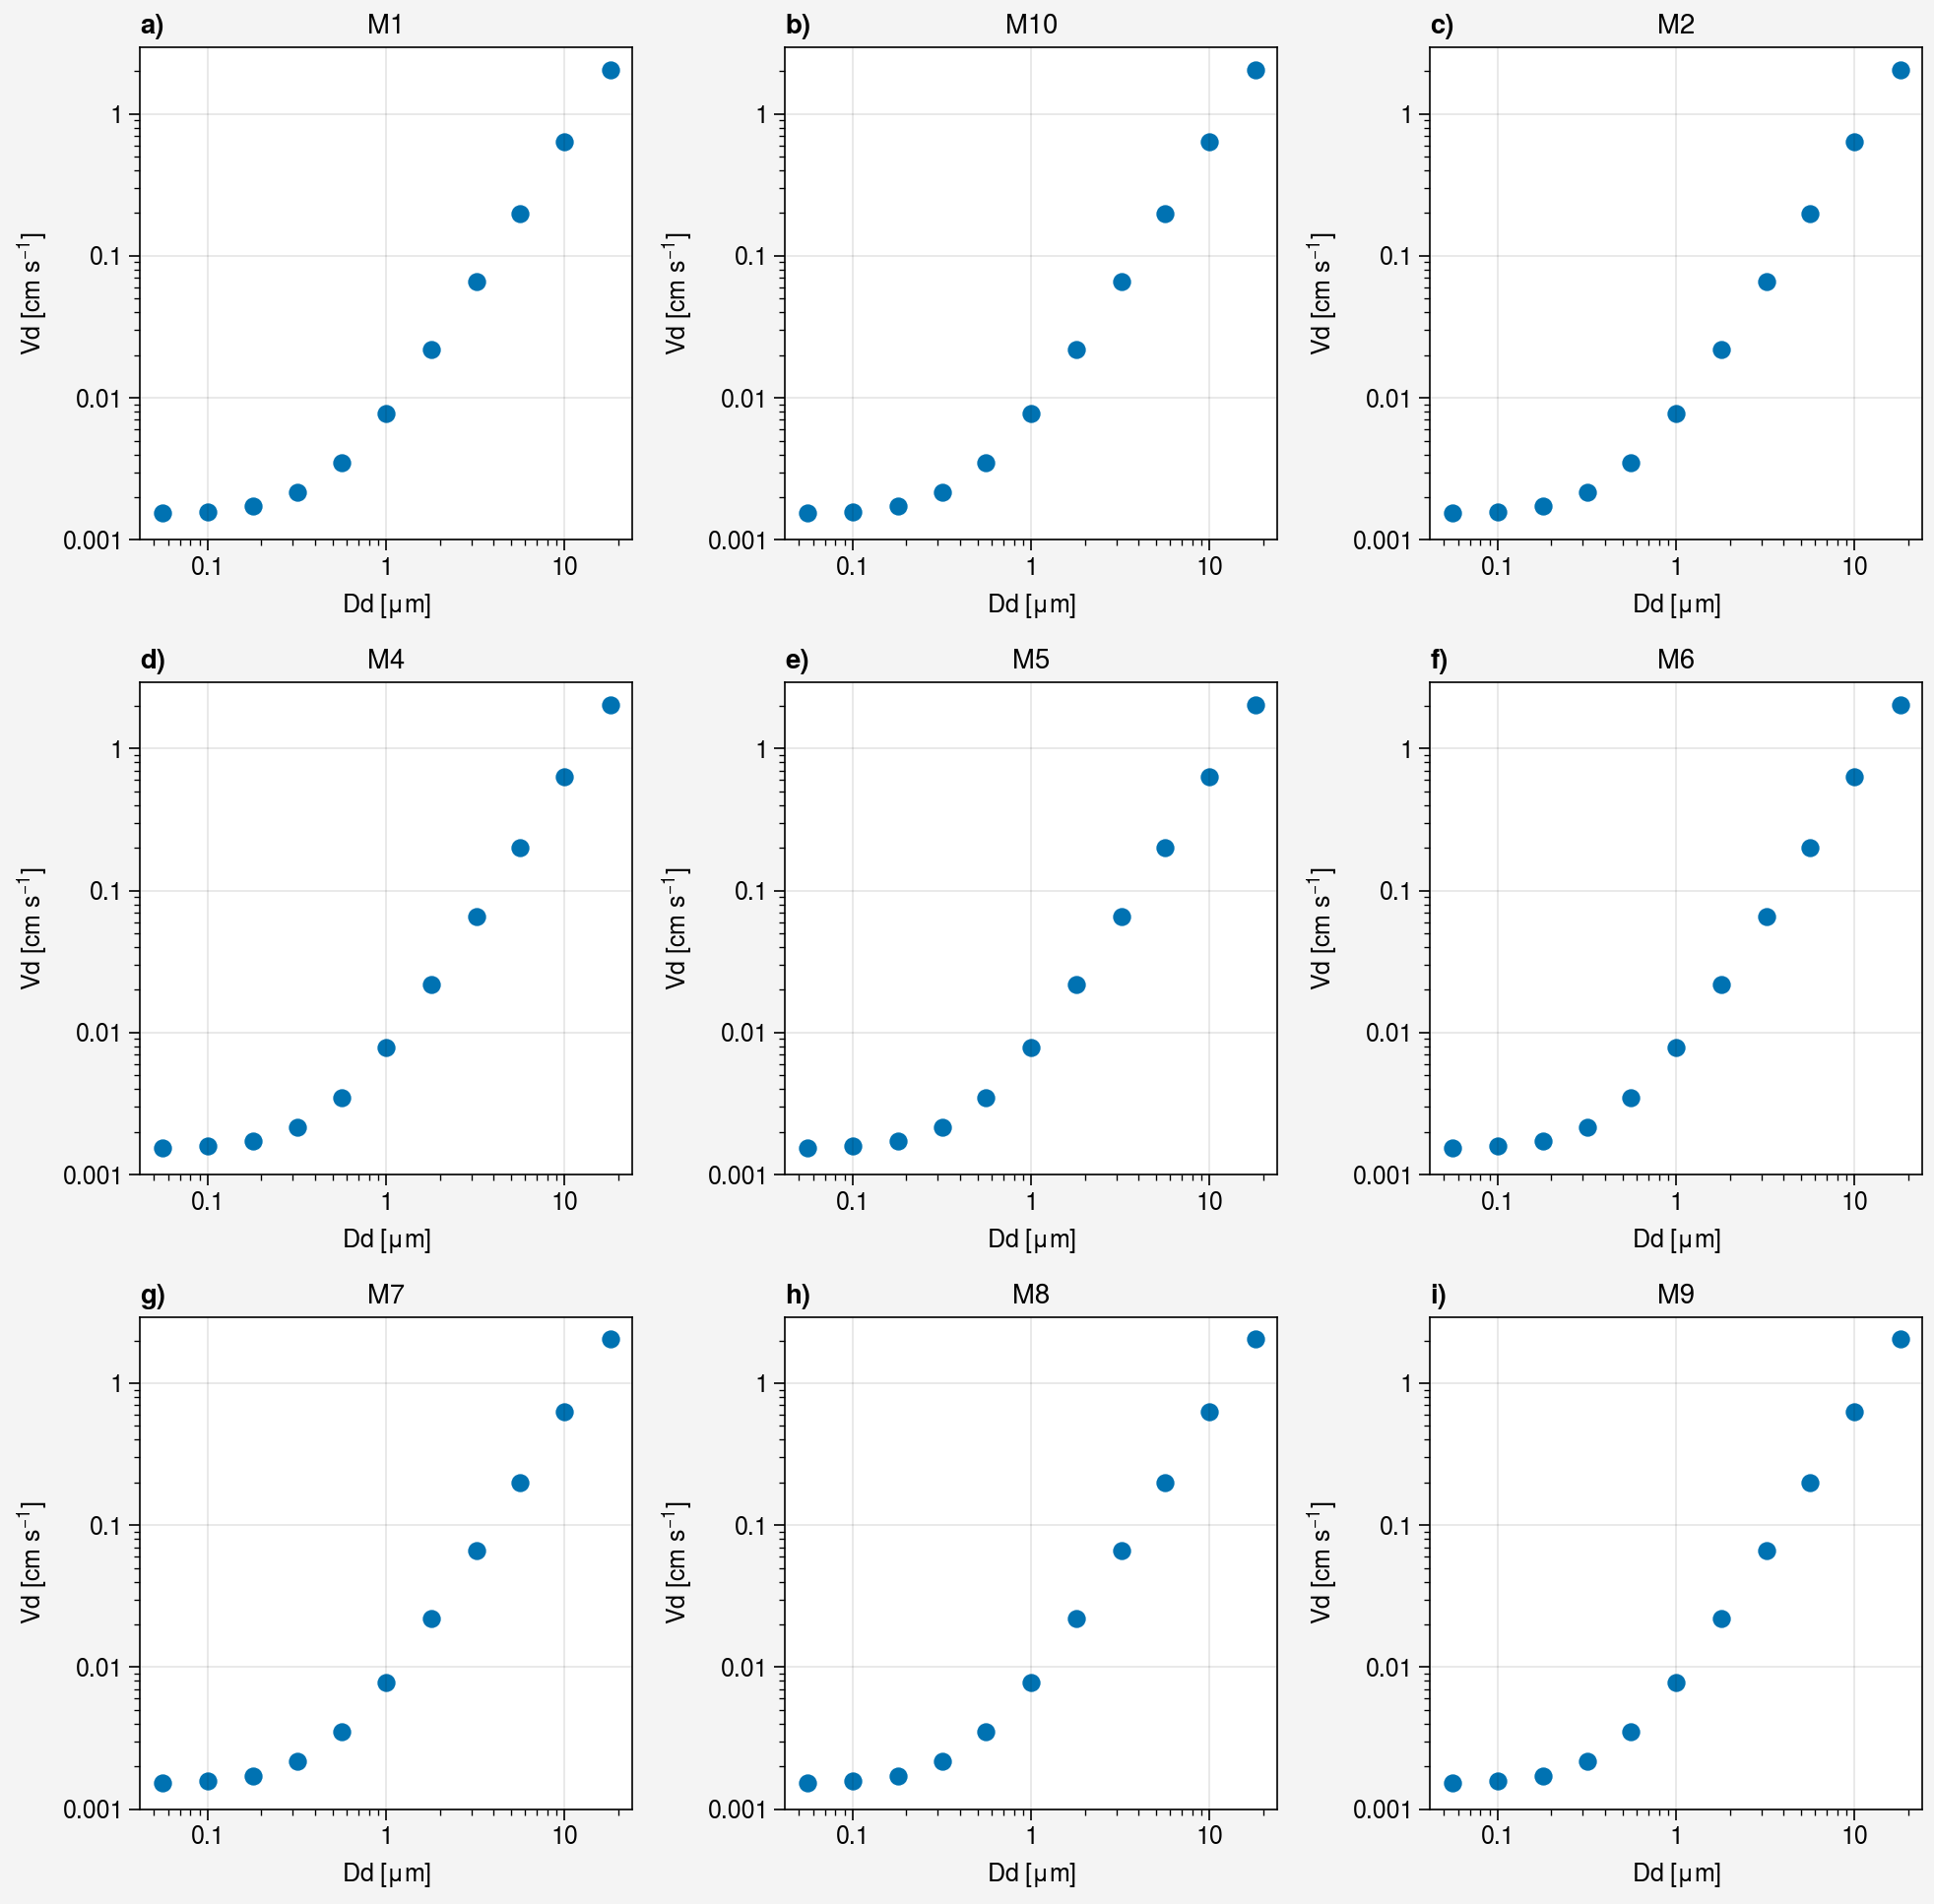

In [4]:
fig, axes = pplt.subplots(ncols=3, nrows=3, share=False)
for idx,keyname in enumerate(MOUDI_mean.groups.keys()):
    sample = MOUDI_mean.get_group((keyname))
    axes[idx].scatter(sample['Dd']*1e6, # Dd单位 :m->um; 
                      sample['vd']*1e2  # vd单位 :m/s->cm/s; 
                      )
    axes[idx].format(title=keyname)
axes.format(
            abc='a)',
            xlabel='Dd [$\mu m$]',
            ylabel='Vd [cm $s^{-1}$]',
            xscale='log',
            yscale='log',
            ymin=0.001
            )  